In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras 
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

In [2]:
IMG_SIZE = (299, 299) # resolution
directory = "C:\\Users\\HP\\Documents\\SDAD_S3\\env\\Detection des maladies des plantes\\data"
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',#jeu de données d'entrainement
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',#jeu de données de validation
                                             color_mode='rgb',
                                             seed=42)

Found 4187 files belonging to 4 classes.
Using 3769 files for training.
Found 4187 files belonging to 4 classes.
Using 418 files for validation.


In [3]:
class_names = train_dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

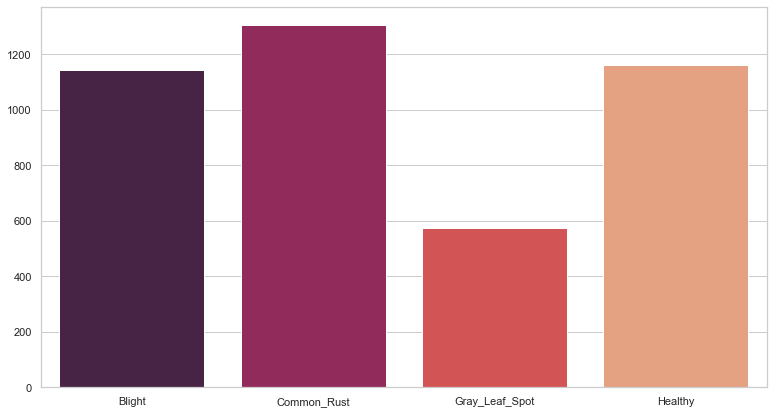

In [37]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=["Blight","Common_Rust","Gray_Leaf_Spot","Healthy"], y=Data_imbalance, palette="rocket")
plt.show()

In [38]:
total = 0 
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i] 
    
weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))  

Weight for class 0: 0.91
Weight for class 1: 0.80
Weight for class 2: 1.82
Weight for class 3: 0.90


In [40]:
Data_imbalance


[1145, 1306, 574, 1162]

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

In [7]:
data_augmentation

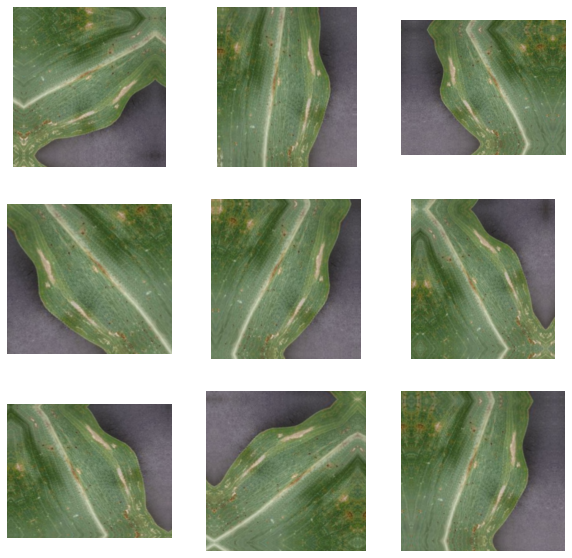

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[5]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
plt.figure(figsize=(20,18))
Common_Rust = []
Gray_Leaf_Spot = []
Corn_Northern_Leaf_Blight =[]
Healthy=[]
for images , labels in train_dataset.take(1):
    for i in range(100):
        if class_names[labels[i]] == "Common_Rust":
            Common_Rust.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Gray_Leaf_Spot":   
            Gray_Leaf_Spot.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Blight":   
            Corn_Northern_Leaf_Blight.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Healthy":   
            Healthy.append(images[i].numpy().astype("uint8"))   


<Figure size 1440x1296 with 0 Axes>

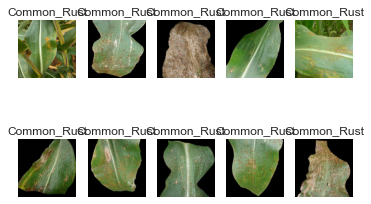

In [10]:
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Common_Rust[i])
    plt.axis("off")
    plt.title("Common_Rust")

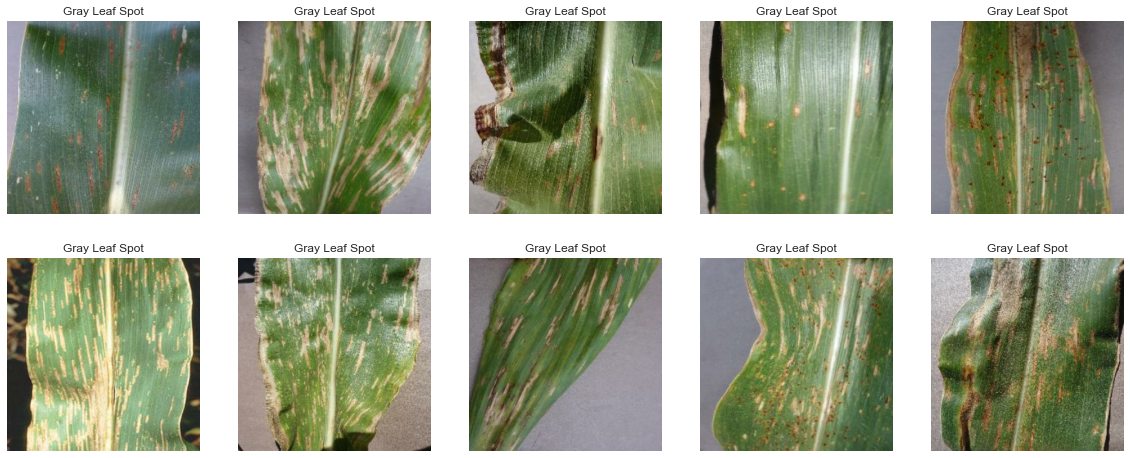

In [11]:
plt.figure(figsize=(20,8))
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Gray_Leaf_Spot[i])
    plt.axis("off")
    plt.title("Gray Leaf Spot")

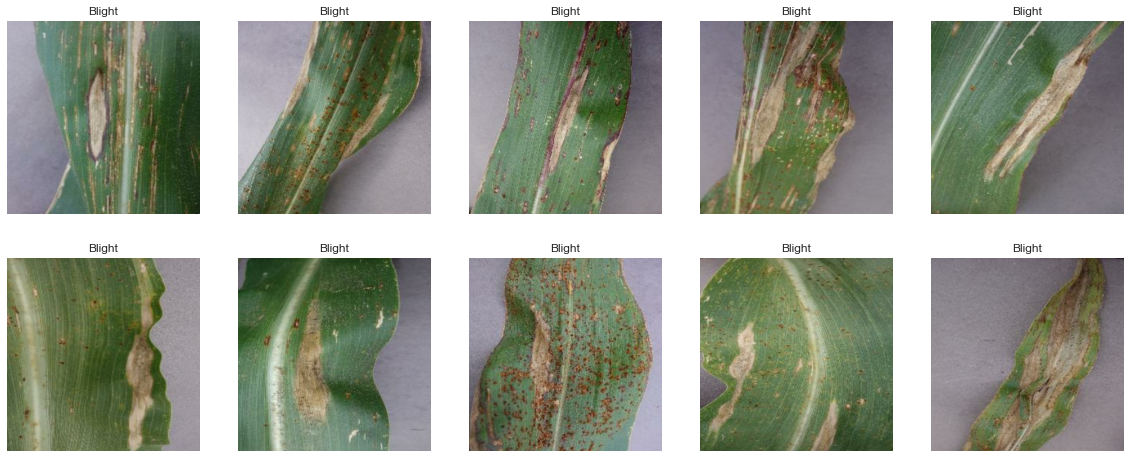

In [12]:
plt.figure(figsize=(20,8))
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Corn_Northern_Leaf_Blight[i])
    plt.axis("off")
    plt.title("Blight")

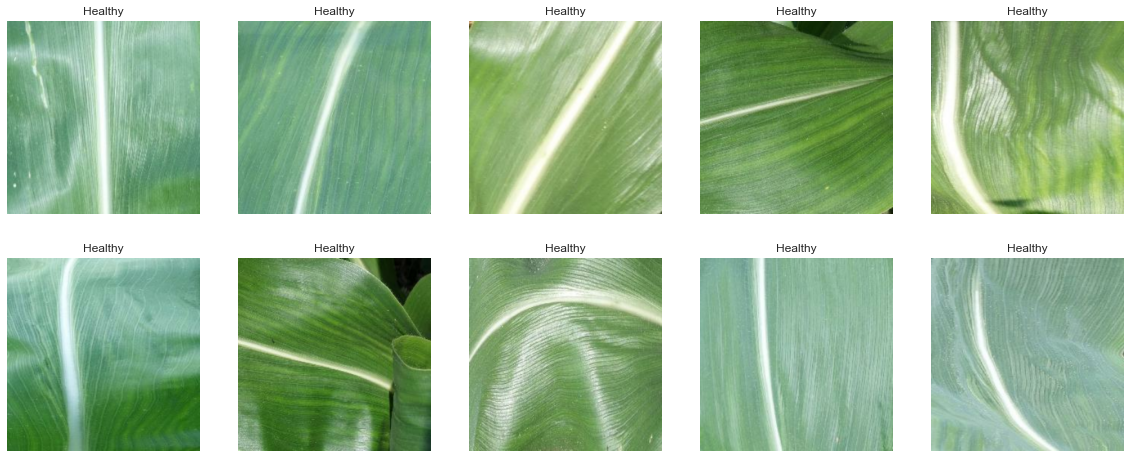

In [13]:
plt.figure(figsize=(20,8))
for i in range(10):            
    plt.subplot(2,5,i+1)
    plt.imshow(Healthy[i])
    plt.axis("off")
    plt.title("Healthy")

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### modèle

In [15]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

In [16]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [17]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name) 

Numbers of Layers = 311
activation_93
mixed10


In [18]:
# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 8, 8, 2048)


In [19]:
def plant_leaf_model( image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)
    
    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 291]:
        layer.trainable = False
    
    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(4 ,activation = "softmax") 
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs) 
    model.summary()
    return model
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [20]:
base_learning_rate = 0.001
Plant_Leaf_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

### Entrainement

In [43]:
history = Plant_Leaf_Model.fit(train_dataset  , epochs=10,class_weight=class_weight,validation_data=validation_dataset )

Epoch 1/10
30/30 [==============================] - 755s 24s/step - loss: 0.1766 - accuracy: 0.9369 - val_loss: 0.1887 - val_accuracy: 0.9330
Epoch 2/10
30/30 [==============================] - 723s 23s/step - loss: 0.1160 - accuracy: 0.9631 - val_loss: 0.1792 - val_accuracy: 0.9258
Epoch 3/10
30/30 [==============================] - 801s 26s/step - loss: 0.0792 - accuracy: 0.9785 - val_loss: 0.1804 - val_accuracy: 0.9330
Epoch 4/10
30/30 [==============================] - 753s 24s/step - loss: 0.0615 - accuracy: 0.9846 - val_loss: 0.1766 - val_accuracy: 0.9330
Epoch 5/10
30/30 [==============================] - 748s 24s/step - loss: 0.0429 - accuracy: 0.9894 - val_loss: 0.1939 - val_accuracy: 0.9282
Epoch 6/10
30/30 [==============================] - 715s 23s/step - loss: 0.0319 - accuracy: 0.9923 - val_loss: 0.1698 - val_accuracy: 0.9402
Epoch 7/10
30/30 [==============================] - 707s 23s/step - loss: 0.0245 - accuracy: 0.9944 - val_loss: 0.1765 - val_accuracy: 0.9402
Epoch 

### validation

In [44]:
Plant_Leaf_Model.evaluate(validation_dataset , verbose = 1)

4/4 [==============================] - 87s 17s/step - loss: 0.1822 - accuracy: 0.9426


[0.18218953907489777, 0.9425837397575378]

predicted | actual
1/1 [==============================] - 4s 4s/step


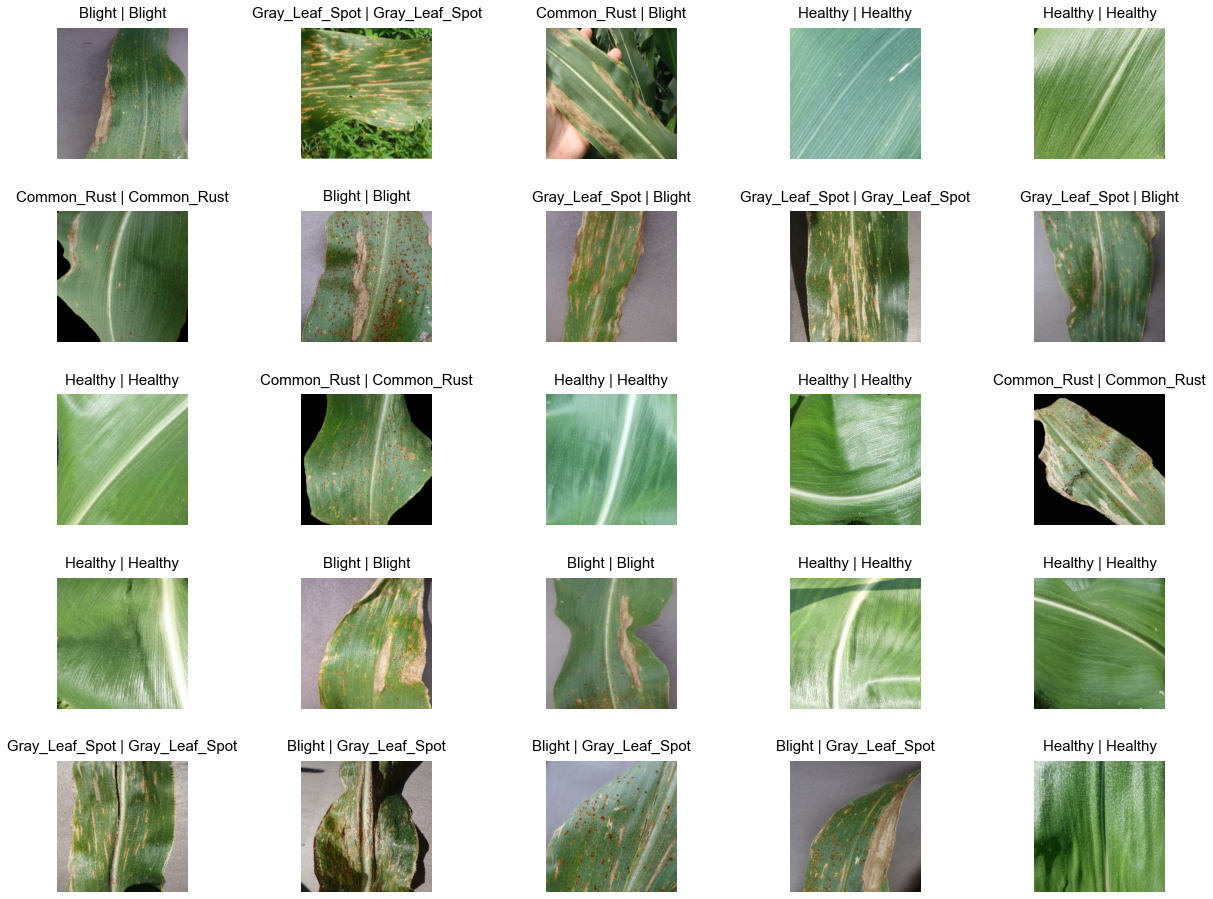

In [45]:
plt.figure(figsize=(20, 15))
print("predicted | actual")
for images, labels in validation_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        res=str(predicted+" | "+actual)
        
        plt.title(res, fontsize=15, color= 'black' ,pad=10); 
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, 
                            top=0.9, wspace=0.4,hspace=0.4)  

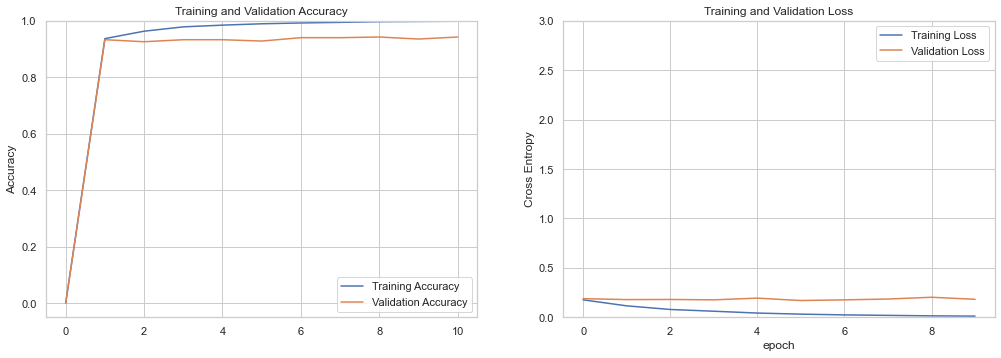

In [46]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [47]:
import tensorflow as tf
y_true = []
y_pred = []
for x,y in validation_dataset:
    
    y_true.append(y)
    y_pred.append(tf.argmax(Plant_Leaf_Model.predict(x),axis = 1))
  

y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

2/2 [==============================] - 13s 459ms/step


In [48]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       105
           1       0.98      0.99      0.98       129
           2       0.87      0.78      0.82        60
           3       0.99      0.99      0.99       124

    accuracy                           0.94       418
   macro avg       0.93      0.92      0.92       418
weighted avg       0.94      0.94      0.94       418



0 : Blight & 1: Common_Rust & 2: Gray_leaf_spot & 3: Healthy


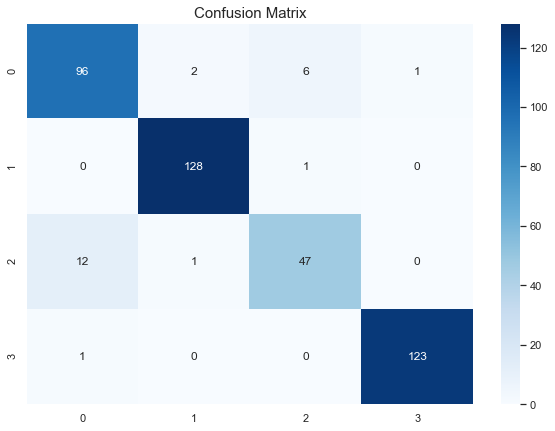

In [49]:
from sklearn.metrics import confusion_matrix
print("0 : Blight & 1: Common_Rust & 2: Gray_leaf_spot & 3: Healthy")
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_true, y_pred), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

In [29]:
y_true

<tf.Tensor: shape=(418,), dtype=int32, numpy=
array([3, 3, 2, 0, 2, 0, 1, 1, 3, 3, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 1,
       3, 3, 3, 0, 3, 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 3, 3, 0, 1, 3, 0, 2,
       0, 2, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 1, 3, 1, 3, 0, 2, 3, 1, 3, 0,
       1, 3, 0, 0, 3, 0, 1, 0, 1, 3, 1, 1, 1, 3, 1, 2, 0, 2, 3, 3, 1, 1,
       3, 2, 1, 0, 1, 2, 3, 0, 0, 0, 2, 1, 1, 1, 1, 0, 3, 3, 3, 1, 1, 0,
       1, 3, 0, 2, 1, 1, 2, 0, 1, 0, 1, 3, 2, 0, 1, 1, 0, 2, 1, 1, 1, 3,
       2, 1, 1, 1, 1, 3, 3, 1, 2, 3, 0, 1, 0, 1, 2, 3, 2, 1, 1, 2, 0, 3,
       1, 2, 3, 0, 0, 0, 3, 0, 0, 1, 1, 3, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 0, 1, 1, 3, 3, 1, 2, 3, 3, 0, 3, 3, 0, 0, 1, 2, 1, 2,
       1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 0, 2, 3, 1, 0, 1, 1, 1, 0, 1, 1, 2,
       1, 3, 3, 0, 1, 3, 3, 2, 3, 1, 3, 0, 2, 0, 3, 2, 1, 3, 0, 3, 1, 3,
       2, 1, 3, 0, 1, 0, 3, 3, 1, 2, 0, 3, 1, 1, 2, 1, 2, 3, 3, 0, 0, 2,
       3, 2, 1, 0, 1, 3, 0, 2, 3, 2, 0, 2, 0, 3, 1, 2, 1, 0, 1, 3, 0, 1,
     

In [30]:
y_pred

<tf.Tensor: shape=(418,), dtype=int64, numpy=
array([3, 3, 2, 0, 0, 2, 0, 1, 3, 3, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 1,
       3, 3, 3, 0, 3, 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 3, 3, 0, 1, 3, 0, 2,
       0, 2, 3, 0, 3, 3, 3, 3, 1, 1, 0, 1, 1, 3, 1, 3, 0, 2, 3, 1, 3, 0,
       1, 3, 0, 0, 3, 0, 1, 0, 1, 3, 1, 1, 1, 3, 1, 2, 0, 2, 3, 3, 1, 1,
       3, 2, 2, 0, 1, 2, 3, 0, 0, 0, 2, 1, 1, 1, 1, 0, 3, 3, 3, 1, 1, 2,
       1, 3, 0, 0, 1, 1, 2, 0, 1, 0, 1, 3, 2, 0, 1, 1, 0, 2, 1, 0, 1, 3,
       2, 1, 1, 1, 1, 3, 3, 1, 2, 3, 0, 1, 0, 1, 2, 3, 2, 1, 1, 2, 0, 3,
       1, 2, 3, 3, 0, 0, 3, 0, 0, 1, 1, 3, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 0, 1, 1, 3, 3, 1, 2, 3, 3, 0, 3, 3, 0, 2, 1, 0, 1, 2,
       1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 0, 0, 3, 1, 2, 1, 1, 1, 0, 1, 1, 2,
       1, 3, 3, 2, 1, 3, 3, 2, 3, 1, 3, 2, 0, 0, 3, 0, 1, 3, 0, 3, 2, 3,
       2, 1, 3, 2, 1, 0, 3, 3, 1, 2, 0, 3, 1, 1, 0, 1, 2, 3, 3, 0, 0, 2,
       3, 2, 1, 0, 1, 3, 0, 2, 3, 2, 0, 0, 1, 3, 0, 2, 1, 0, 1, 3, 2, 1,
     